In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch

labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$"]


tkwargs = {"dtype": torch.float}
save_dir = "small_emittance_case/"
quad_strengths, image_data, bins, xx = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

ensemble.cuda();
covs = []
for i in range(10):
    initial_beam = ensemble[i].beam()
    covs+= [torch.cov(initial_beam.data.T)]

covs = torch.stack(covs)
covs.shape



/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([10, 6, 6])

In [2]:
xemittances = torch.det(covs[3:,:2,:2]).sqrt()*1e6
yemittances = torch.det(covs[3:,2:4,2:4]).sqrt()*1e6
print(f"enx {xemittances.mean()} +/- {xemittances.std()}")
print(f"eny {yemittances.mean()} +/- {yemittances.std()}")


enx 2.212550401687622 +/- 0.023806309327483177
eny 8.856263160705566 +/- 0.22065672278404236


In [3]:
yemittances

tensor([8.5389, 8.6731, 8.8073, 8.8982, 8.9068, 8.9318, 9.2377],
       device='cuda:0', grad_fn=<MulBackward0>)

In [4]:
xemittances

tensor([2.1768, 2.1838, 2.2256, 2.2238, 2.2153, 2.2433, 2.2193],
       device='cuda:0', grad_fn=<MulBackward0>)

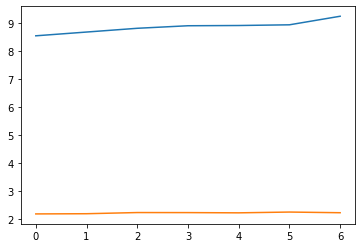

In [5]:
plt.plot(yemittances.cpu().detach())
plt.plot(xemittances.cpu().detach())

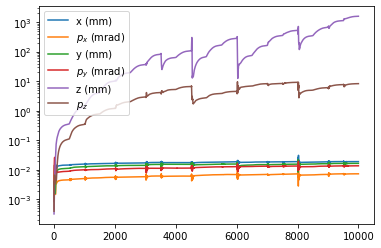

In [6]:
# plot loss record
traces = torch.load(save_dir + "/loss_log.pt")
losses = torch.stack([ele[0] for ele in traces])
tcovs = torch.stack([ele[1] for ele in traces])

# plot convergence
moments = torch.diagonal(tcovs, dim1=-2,dim2=-1)
x = torch.arange(moments.shape[0])

plt.semilogy(moments.cpu().detach()*1e3,label=labels)
plt.legend()